In [4]:
#import xarray as xr
#import dask
import math
import numpy as np

In [5]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/W_Test.npy')

In [6]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.
/export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

In [7]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

In [8]:
#not sure purpose of this guy yet?
codings_size = 10

inputs = keras.layers.Input(shape=[30, 128])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs=[codings_mean, codings_log_var, codings])

W0331 04:16:44.142216 140622528927552 deprecation_wrapper.py:119] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0331 04:16:44.169214 140622528927552 deprecation_wrapper.py:119] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0331 04:16:44.183190 140622528927552 deprecation_wrapper.py:119] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0331 04:16:44.202132 140622528927552 deprecation.py:323] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.p

In [9]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(30*128, activation="sigmoid")(x)
outputs = keras.layers.Reshape([30,128])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [10]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [11]:
latent_loss = -0.5*K.sum(1+codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis = -1)
variational_ae.add_loss(K.mean(latent_loss)/784.)
variational_ae.compile(loss="binary_crossentropy", optimizer ="rmsprop")
variational_ae.summary()

W0331 04:16:44.648428 140622528927552 deprecation_wrapper.py:119] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0331 04:16:44.668706 140622528927552 deprecation_wrapper.py:119] From /export/home/gmooers/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 128)           0         
_________________________________________________________________
model_1 (Model)              [(None, 10), (None, 10),  593270    
_________________________________________________________________
model_2 (Model)              (None, 30, 128)           596090    
Total params: 1,189,360
Trainable params: 1,189,360
Non-trainable params: 0
_________________________________________________________________


In [12]:
h = variational_ae.fit(Training_Images, Training_Images, epochs=10, batch_size=128, validation_data=[Test_Images, Test_Images])

Train on 8284 samples, validate on 2180 samples
Epoch 1/10
8284/8284 [==============================] - 3s 362us/step - loss: 1.7105 - val_loss: 0.5928
Epoch 2/10
8284/8284 [==============================] - 2s 276us/step - loss: 0.5937 - val_loss: 0.5840
Epoch 3/10
8284/8284 [==============================] - 2s 244us/step - loss: 0.5916 - val_loss: 0.5810
Epoch 4/10
8284/8284 [==============================] - 2s 232us/step - loss: 0.5819 - val_loss: 0.5750
Epoch 5/10
8284/8284 [==============================] - 2s 235us/step - loss: 0.5805 - val_loss: 0.5773
Epoch 6/10
8284/8284 [==============================] - 2s 235us/step - loss: 0.5765 - val_loss: 0.5750
Epoch 7/10
8284/8284 [==============================] - 2s 229us/step - loss: 0.5745 - val_loss: 0.5749
Epoch 8/10
8284/8284 [==============================] - 2s 234us/step - loss: 0.5730 - val_loss: 0.5725
Epoch 9/10
8284/8284 [==============================] - 2s 233us/step - loss: 0.5723 - val_loss: 0.5715
Epoch 10/10
8284

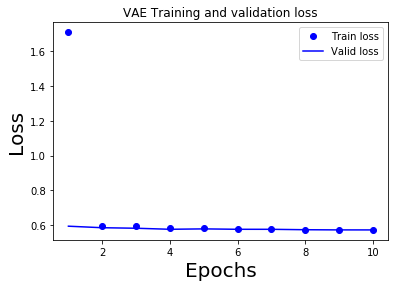

In [15]:
import matplotlib.pyplot as plt

hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()

In [14]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'